<a href="https://colab.research.google.com/github/kdChen07/progress-and-problems/blob/main/SPOPT_LSCP_%E6%95%99%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real World Facility Location Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

This tutorial aims to show a facility location application. To achieve this goal the tuorial will solve a real world facility location problem using a dataset describing an area of census tract 205, San Francisco. The problem can be written as: store sites should supply the demand in this census tract considering the distance between the two sites, a demand point and a supply candidate site. 

This tutorial model this problem using four models already developed in literature: LSCP (Location Set Covering Problem), MCLP (Maximal Coverage Location Problem), P-Median and P-Center. If you don't know any of these models, it's recommended to see the notebooks that explain more deeply about each model: [LSCP](./lscp.ipynb), [MCLP](./mclp.ipynb), [P-Median](./p-median.ipynb), [P-Center](./p-center.ipynb)

Besides that, the tutorial show how to use different solvers that [PULP](https://github.com/coin-or/pulp) support.

In [ ]:
!pip install geopandas
!pip install pulp

In [ ]:
import numpy
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt
from google.colab import files

The problem is composed by 4 datafiles
- network_distance is the calculus of distance between facility candidate sites calculated by ArcGIS Network Analyst Extension
- demand_points represents the demand points with some important features for the facility location problem like population
- facility_points represents the stores that are candidate facility sites
- tract is the polygon of census tract 205.

All datasets are online on this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store)

In [ ]:
network_distance = pandas.read_csv("SF_network_distance_candidateStore_16_censusTract_205_new.csv")
demand_points = pandas.read_csv("SF_demand_205_centroid_uniform_weight.csv", index_col=0)
facility_points = pandas.read_csv("SF_store_site_16_longlat.csv", index_col=0)
tract = geopandas.read_file("ServiceAreas_4.shp")

Display network_distance dataframe

In [ ]:
display(network_distance)

,distance,name,DestinationName,demand
0,671.573346,Store_1,60750479.01,6540
1,1333.708063,Store_1,60750479.02,3539
2,1656.188884,Store_1,60750352.02,4436
3,1783.006047,Store_1,60750602.00,231
4,1790.950612,Store_1,60750478.00,7787
...,...,...,...,...
3275,19643.307257,Store_19,60816023.00,3204
3276,20245.369594,Store_19,60816029.00,4135
3277,20290.986235,Store_19,60816026.00,7887
3278,20875.680521,Store_19,60816025.00,5146


Display demand points dataframe

In [ ]:
display(demand_points)

,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
1,1,6081602900,60816029.00,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
2,2,6081602800,60816028.00,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
3,3,6081601700,60816017.00,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
4,4,6081601900,60816019.00,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
5,5,6081602500,60816025.00,California,0.46603,5146,1459,1467,44,-122.451187,37.640219
...,...,...,...,...,...,...,...,...,...,...,...
201,204,6075011100,60750111.00,California,0.09466,5559,2930,3037,362,-122.418479,37.791082
202,205,6075012200,60750122.00,California,0.07211,7035,3862,4074,272,-122.417237,37.785728
203,206,6075017601,60750176.01,California,0.24306,5756,2437,2556,943,-122.410115,37.779459
204,207,6075017800,60750178.00,California,0.27882,5829,3115,3231,807,-122.405411,37.778934


Display facility_points dataframe

In [ ]:
display(facility_points)

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545
6,6,Store_6,-122.491745,37.649309
7,7,Store_7,-122.483182,37.701109
8,8,Store_11,-122.433782,37.655364
9,9,Store_12,-122.438982,37.719236
10,10,Store_13,-122.440218,37.745382


Plot tract

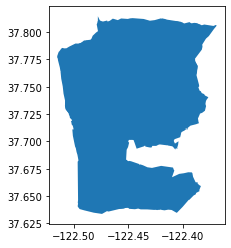

In [ ]:
tract.plot()

In [ ]:
tract

,geometry
0,"POLYGON ((-122.45084 37.68222, -122.44942 37.6..."
1,"POLYGON ((-122.41912 37.75941, -122.40938 37.7..."
2,"POLYGON ((-122.42153 37.78677, -122.41859 37.7..."
3,"POLYGON ((-122.42026 37.80690, -122.41879 37.8..."
4,"POLYGON ((-122.47539 37.81033, -122.47327 37.8..."
5,"POLYGON ((-122.41519 37.81151, -122.40235 37.8..."
6,"POLYGON ((-122.48282 37.78324, -122.48343 37.7..."
7,"POLYGON ((-122.46339 37.76489, -122.46381 37.7..."
8,"POLYGON ((-122.48407 37.78281, -122.48438 37.7..."
9,"POLYGON ((-122.43948 37.78427, -122.43864 37.7..."


To start modeling the problem assuming the arguments expected by `spopt.locate`, we should pass a numpy 2D array as a cost_matrix. So, first we pivot the network_distance dataframe. 

_Note that the columns and rows are in alphabetically order._

In [ ]:
ntw_dist_piv = network_distance.pivot_table(values="distance", index="DestinationName", columns="name")
ntw_dist_piv

name,Store_1,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7
DestinationName,,,,,,,,,,,,,,,,
60750101.0,11495.190454,20022.666503,10654.593733,8232.543149,7561.399789,4139.772198,4805.805279,2055.530234,225.609240,1757.623456,11522.519829,7529.985950,10847.234951,10604.729605,20970.277793,15242.989416
60750102.0,10436.169910,19392.094770,10024.022001,7601.971416,6930.828057,3093.851654,4175.233547,1257.809690,1041.911304,2333.244000,10509.099285,6470.965406,10216.663219,9974.157873,20339.706061,14612.417684
60750103.0,10746.296811,19404.672860,10036.600090,7614.549505,6943.406146,3381.778555,4187.811636,2046.436590,744.584403,1685.517099,10800.926186,6778.892307,10229.241308,9986.735962,20352.284150,14624.995773
60750104.0,11420.492134,19808.368182,10440.295413,8018.244828,7347.101469,4044.473877,4591.506959,2463.736278,795.715285,1282.217412,11308.221508,7447.187630,10632.936630,10390.431285,20755.979472,15028.691095
60750105.0,11379.443952,19583.920000,10215.847231,7793.796646,7122.653287,4103.725695,4367.058776,3320.283731,1731.462738,249.669959,11083.773326,7379.539448,10408.488448,10165.983103,20531.531290,14804.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60816025.0,17324.066610,2722.031291,10884.063331,14178.007937,13891.857275,18418.384867,16726.951785,20834.395022,21441.247824,20875.680521,14662.484617,16569.371114,12483.322114,11926.727459,4968.842581,8648.054204
60816026.0,15981.172325,3647.137006,10299.369046,13593.313651,13307.162990,17833.690581,16142.257500,20249.700736,20856.553539,20290.986235,14050.290332,15963.776829,11871.527828,11342.033174,3625.948296,7919.659919
60816027.0,14835.342712,4581.333336,9637.139433,12931.084039,12644.933377,17171.460969,15480.027887,19587.471124,20194.323926,19628.756623,13341.313338,15301.547216,11209.298215,10679.803561,2290.818683,7242.830306


Here the pivot table is transformed to numpy 2D array such as `spopt.locate` expected. The matrix has a shape of 205x16.

In [ ]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix

array([[11495.19045438, 20022.66650296, 10654.59373325, ...,
        10604.72960533, 20970.27779306, 15242.98941606],
       [10436.16991032, 19392.09477041, 10024.0220007 , ...,
         9974.15787278, 20339.70606051, 14612.41768351],
       [10746.29681106, 19404.67285964, 10036.60008993, ...,
         9986.73596201, 20352.28414974, 14624.99577275],
       ...,
       [14835.34271218,  4581.3333364 ,  9637.13943331, ...,
        10679.80356124,  2290.81868301,  7242.83030602],
       [13339.49169134,  6392.85637207,  8577.48841247, ...,
         9620.15254039,  1846.79564734,  5746.97928517],
       [15257.85568393,  6394.92036466, 10253.75240505, ...,
        11296.41653298,   508.93165475,  7665.34327776]])

Now, as the rows and columns of our cost_matrix are sorted, so we have to sort our facility points and demand points geodataframes too. 

In [ ]:
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,
    geometry=geopandas.points_from_xy(
        facility_points.long, facility_points.lat
    ),
).sort_values(by=['NAME']).reset_index()

demand_points_gdf = geopandas.GeoDataFrame(
    demand_points,
    geometry=geopandas.points_from_xy(demand_points.long, demand_points.lat),
).sort_values(by=['NAME']).reset_index()

Here the rest of parameters are set. The ai is the demand weight and in this case we model as population in year 2000 of this tract.

In [ ]:
ai = demand_points_gdf['POP2000'].to_numpy()

service_dist = 5000
p_facility = 4

In [ ]:
facility_points_gdf

,index,OBJECTID,NAME,long,lat,geometry
0,1,1,Store_1,-122.510018,37.772364,POINT (-122.51002 37.77236)
1,8,8,Store_11,-122.433782,37.655364,POINT (-122.43378 37.65536)
2,9,9,Store_12,-122.438982,37.719236,POINT (-122.43898 37.71924)
3,10,10,Store_13,-122.440218,37.745382,POINT (-122.44022 37.74538)
4,11,11,Store_14,-122.421636,37.742964,POINT (-122.42164 37.74296)
5,12,12,Store_15,-122.430982,37.782964,POINT (-122.43098 37.78296)
6,13,13,Store_16,-122.426873,37.769291,POINT (-122.42687 37.76929)
7,14,14,Store_17,-122.432345,37.805218,POINT (-122.43235 37.80522)
8,15,15,Store_18,-122.412818,37.805745,POINT (-122.41282 37.80575)
9,16,16,Store_19,-122.398909,37.797073,POINT (-122.39891 37.79707)


In [ ]:
demand_points_gdf

,index,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat,geometry
0,136,139,6075010100,60750101.0,California,0.29101,2879,1760,1944,538,-122.411303,37.805357,POINT (-122.41130 37.80536)
1,195,198,6075010200,60750102.0,California,0.19945,4288,2767,3044,256,-122.421828,37.802668,POINT (-122.42183 37.80267)
2,196,199,6075010300,60750103.0,California,0.10470,4092,2092,2327,78,-122.415181,37.801253,POINT (-122.41518 37.80125)
3,191,194,6075010400,60750104.0,California,0.13005,4859,2630,2899,209,-122.407959,37.802354,POINT (-122.40796 37.80235)
4,42,42,6075010500,60750105.0,California,0.26295,2217,1521,1843,925,-122.399952,37.798735,POINT (-122.39995 37.79874)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,5,5,6081602500,60816025.0,California,0.46603,5146,1459,1467,44,-122.451187,37.640219,POINT (-122.45119 37.64022)
201,11,11,6081602600,60816026.0,California,0.55573,7887,2335,2357,159,-122.462271,37.646861,POINT (-122.46227 37.64686)
202,6,6,6081602700,60816027.0,California,0.70165,5539,1794,1830,56,-122.475987,37.650538,POINT (-122.47599 37.65054)
203,2,2,6081602800,60816028.0,California,0.47478,4831,1484,1506,59,-122.483550,37.659998,POINT (-122.48355 37.66000)


Below, the method is used to plot the results of the four models that we will prepare to solve the problem.

In [ ]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points_gdf, demand_points_gdf, facility_count, title):
    arr_points = []
    fac_sites = []
    
    for i in range(facility_count):
        if model.fac2cli[i]:

            geom = demand_points_gdf.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(12, 12))
    legend_elements = []

    tract.plot(ax=ax, alpha=1, color='tan', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='tan',
        label='tract',
    ))

    facility_points_gdf.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={facility_count})'
    ))

    demand_points_gdf.plot(ax=ax, edgecolor='k', color='white', zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='white',
        marker="o",
        markeredgecolor='k',
        linewidth=0,
        label=f'clients not covered'
    ))
 
    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        label = f"points covered by {facility_points_gdf.iloc[[fac_sites[i]]]['NAME'].squeeze()}"
        legend_elements.append(Patch(facecolor=dv_colors[i], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=dv_colors[i], label=label)
        facility_points_gdf.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"{facility_points_gdf.iloc[[fac_sites[i]]]['NAME'].squeeze()}",
        ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

## LSCP

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/spopt-gsoc21-facloc

/content/drive/MyDrive/Colab Notebooks/spopt-gsoc21-facloc


In [ ]:
!python setup.py install

In [ ]:
from spopt.locate.coverage import LSCP

In [ ]:
!sudo apt-get install python-glpk
!sudo apt-get install glpk-utils

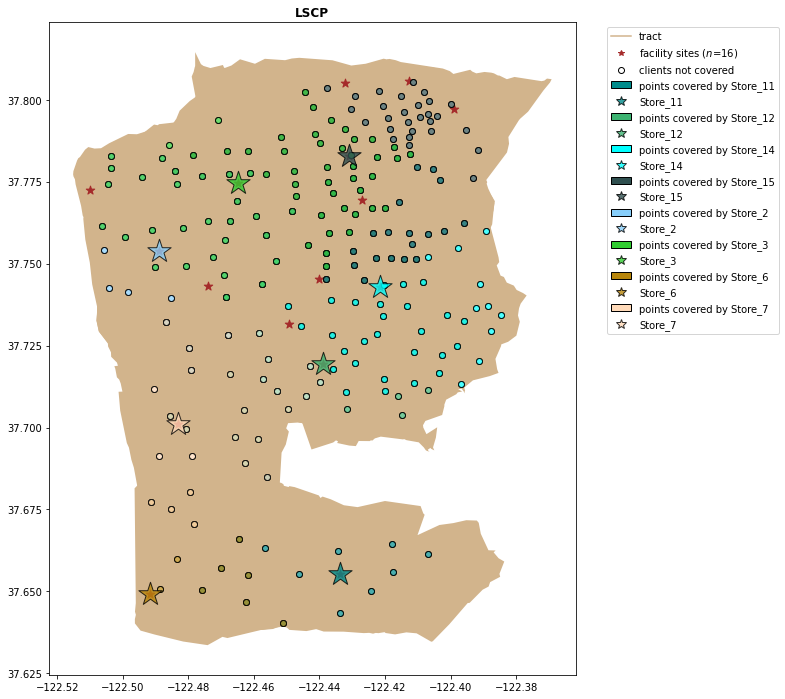

In [ ]:
lscp = LSCP.from_cost_matrix(cost_matrix, service_dist)
lscp = lscp.solve(pulp.GLPK(msg=False))

lscp.facility_client_array()
plot_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP")

## MCLP

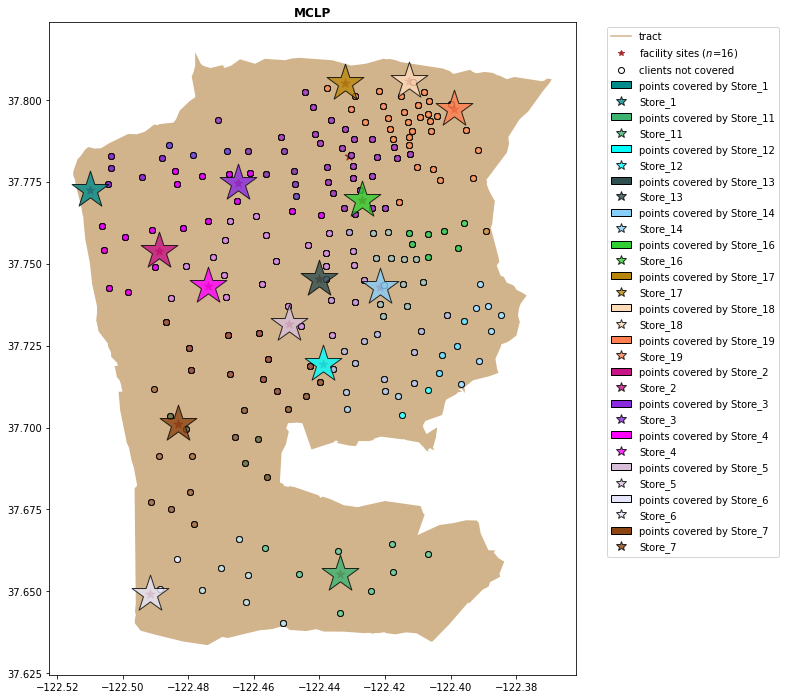

In [ ]:
from spopt.locate.coverage import MCLP

mclp = MCLP.from_cost_matrix(
            cost_matrix,
            ai,
            max_coverage=service_dist,
            p_facilities=15,
        )
mclp = mclp.solve(pulp.GLPK(msg=False))

mclp.facility_client_array()
plot_results(mclp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "MCLP")

### MCLP Percentage Covered

In [ ]:
mclp.uncovered_clients_dict()
mclp.get_percentage()
mclp.percentage

0.8975609756097561

## P-Center

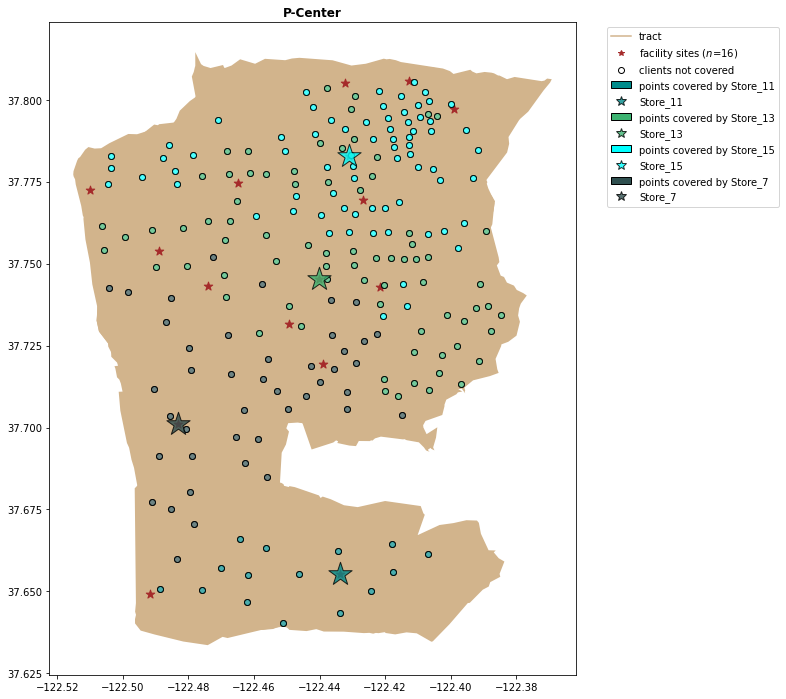

In [ ]:
from spopt.locate import PCenter
pcenter = PCenter.from_cost_matrix(
    cost_matrix, ai, p_facilities=p_facility
)
pcenter = pcenter.solve(pulp.GLPK(msg=False))
pcenter.facility_client_array()
plot_results(pcenter, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "P-Center")

## P-Median

In [ ]:
from spopt.locate import PMedian
pmedian = PMedian.from_cost_matrix(
    cost_matrix, ai, p_facilities=p_facility
)
pmedian = pmedian.solve(pulp.GLPK(msg=False))
pmedian.facility_client_array()
plot_results(pmedian, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "P-Median")

ModuleNotFoundError: ignored

In [ ]:
pmedian.get_mean_distance(weight=ai)
pmedian.mean_dist

2982.1268579890657

## Using different solver for one model

For this task we get the MCLP model as example.

In [ ]:
from spopt.locate.coverage import MCLP

mclp = MCLP.from_cost_matrix(
            cost_matrix,
            ai,
            max_coverage=service_dist,
            p_facilities=4,
        )

First, it's good to see which solver you have installed in your machine.

In [ ]:
solvers = pulp.listSolvers(onlyAvailable=True)
solvers

['GLPK_CMD',
 'CPLEX_CMD',
 'GUROBI_CMD',
 'PULP_CBC_CMD',
 'COIN_CMD',
 'PULP_CHOCO_CMD']

Above we can see that it returns a list with different solvers that are available. So, it's up to user choose one of chosse the best solver that fits the model. Let's get the percentage as a metric to evaluate which solver is the best or ehich improves the model. We will not use the PULP_CHOCO_CMD for time purposes.

In [ ]:
for i in range(len(solvers)-1):
    mclp = mclp.solve(pulp.get_solver(solvers[i]))
    mclp.facility_client_array()
    mclp.uncovered_clients_dict()
    mclp.get_percentage()
    percentage = mclp.percentage

    print(f"Solver: {solvers[i]} - Percentage: {percentage}")

Solver: GLPK_CMD - Percentage: 0.8975609756097561
Solver: CPLEX_CMD - Percentage: 0.8975609756097561
Solver: GUROBI_CMD - Percentage: 0.8975609756097561
Solver: PULP_CBC_CMD - Percentage: 0.8975609756097561
Solver: COIN_CMD - Percentage: 0.8975609756097561
